# Data Story Telling

In the journal we will explore a synthetic data set from Kaggle describing the symptoms and test results of patients tested for Covid-19.

This data set contains information on 5000 hypothetical patients.  Values include whether the patient presented with symptoms (Yes or No) such as fever, dry cough, fatigue, loss of smell etc.  The data set also includes any comorbidities that patient has and whether the patient had contact with someone who was positive for Covid-19.  While this data set was originally designed to model development to predict the patients covid status based on symptoms, we will do exporaotry data analysis to understand the stories this data can tell us.

To start, please remove the hashtag in the following windown to install `matplotlib-venn` and `upsetplot` if they are not already installed on your machine.

In [7]:
# %pip install matplotlib-venn
# %pip install upsetplot

Please import the following libraries...

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib_venn import venn3 
from upsetplot import from_indicators, UpSet

import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="upsetplot"
)

...and read the dataset in the variable `covid`.

In [9]:
covid = pd.read_csv('covid19_patient_symptoms_diagnosis.csv')
covid.head()

,patient_id,age,gender,fever,dry_cough,sore_throat,fatigue,headache,shortness_of_breath,loss_of_smell,loss_of_taste,oxygen_level,body_temperature,comorbidity,travel_history,contact_with_patient,chest_pain,covid_result
0,1,52,Male,1,0,1,1,0,0,0,0,98,37.1,Diabetes,0,0,0,0
1,2,15,Male,0,0,0,1,1,0,0,0,85,37.7,Diabetes,0,1,0,0
2,3,72,Male,1,0,1,0,0,1,0,1,99,36.8,NaN,0,0,0,0
3,4,61,Female,0,0,1,1,1,0,1,1,86,36.0,NaN,1,0,0,0
4,5,21,Female,1,1,0,0,0,1,0,1,90,36.4,NaN,1,1,1,1


In [10]:
covid.shape

(5000, 18)

## Data Cleaning

Before getting into the EDA, we'll prepare the data.  While 1/0 coding is perfect for machine learning, it can be opaque to when interpreting visuals.  Let's change 0 to No and 1 to Yes for the symptoms.  For the covid results, we'll use Negative and Positive.

In [11]:
categorical_columns = ['fever', 'dry_cough', 'sore_throat',
       'fatigue', 'headache', 'shortness_of_breath', 'loss_of_smell',
       'loss_of_taste', 'travel_history', 'contact_with_patient', 'chest_pain']
values = {0:'No', 1:'Yes'}
for col in categorical_columns:
    covid[col] = covid[col].map(values)
covid['covid_result'] = covid['covid_result'].map({0:'Negative', 1:'Positive'})
covid.head()

,patient_id,age,gender,fever,dry_cough,sore_throat,fatigue,headache,shortness_of_breath,loss_of_smell,loss_of_taste,oxygen_level,body_temperature,comorbidity,travel_history,contact_with_patient,chest_pain,covid_result
0,1,52,Male,Yes,No,Yes,Yes,No,No,No,No,98,37.1,Diabetes,No,No,No,Negative
1,2,15,Male,No,No,No,Yes,Yes,No,No,No,85,37.7,Diabetes,No,Yes,No,Negative
2,3,72,Male,Yes,No,Yes,No,No,Yes,No,Yes,99,36.8,NaN,No,No,No,Negative
3,4,61,Female,No,No,Yes,Yes,Yes,No,Yes,Yes,86,36.0,NaN,Yes,No,No,Negative
4,5,21,Female,Yes,Yes,No,No,No,Yes,No,Yes,90,36.4,NaN,Yes,Yes,Yes,Positive


In [12]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   patient_id            5000 non-null   int64  
 1   age                   5000 non-null   int64  
 2   gender                5000 non-null   object 
 3   fever                 5000 non-null   object 
 4   dry_cough             5000 non-null   object 
 5   sore_throat           5000 non-null   object 
 6   fatigue               5000 non-null   object 
 7   headache              5000 non-null   object 
 8   shortness_of_breath   5000 non-null   object 
 9   loss_of_smell         5000 non-null   object 
 10  loss_of_taste         5000 non-null   object 
 11  oxygen_level          5000 non-null   int64  
 12  body_temperature      5000 non-null   float64
 13  comorbidity           2275 non-null   object 
 14  travel_history        5000 non-null   object 
 15  contact_with_patient 

This successfully changed out catergorical columns to objects.  There are two continuous, numerical columns for the patients oxygen level and body temperature.  Let's take a quick look at those.

In [13]:
covid.describe()

,patient_id,age,oxygen_level,body_temperature
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,44.380600,91.934200,38.500480
std,1443.520003,25.551632,4.300275,1.431892
min,1.000000,1.000000,85.000000,36.000000
25%,1250.750000,22.000000,88.000000,37.300000
50%,2500.500000,44.000000,92.000000,38.500000
75%,3750.250000,66.000000,96.000000,39.700000
max,5000.000000,89.000000,99.000000,41.000000


There isn't anything suspicious about those results, so let's finish the data cleaning by filling in missing data.

In [14]:
covid.isna().sum()

patient_id                 0
age                        0
gender                     0
fever                      0
dry_cough                  0
sore_throat                0
fatigue                    0
headache                   0
shortness_of_breath        0
loss_of_smell              0
loss_of_taste              0
oxygen_level               0
body_temperature           0
comorbidity             2725
travel_history             0
contact_with_patient       0
chest_pain                 0
covid_result               0
dtype: int64

In [15]:
covid['comorbidity'] = covid['comorbidity'].fillna('Unknown')

In [16]:
covid.isna().sum()

patient_id              0
age                     0
gender                  0
fever                   0
dry_cough               0
sore_throat             0
fatigue                 0
headache                0
shortness_of_breath     0
loss_of_smell           0
loss_of_taste           0
oxygen_level            0
body_temperature        0
comorbidity             0
travel_history          0
contact_with_patient    0
chest_pain              0
covid_result            0
dtype: int64

We only found missing values in the comorbidity column, and filled those with the category "Unknown".  The dataset is now ready for EDA.

## Data Storytelling

Let's first look a how each reported symptom relates to the results of the patients covid test.  We'll look at this a few ways, starting with a barplot showing the prevalenace of symptoms in Covid Positive patients.

In [37]:
symptom_columns = ['fever', 'dry_cough', 'sore_throat',
       'fatigue', 'headache', 'shortness_of_breath', 'loss_of_smell',
       'loss_of_taste', 'travel_history', 'contact_with_patient', 'chest_pain']

In [ ]:
#Calculate the percentage of Covid Positive Patients with and without each symptom.
percent_yes = []
for col in symptom_columns:
    pct_yes = covid[covid[col] =='Yes']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    pct_no = covid[covid[col] =='No']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    percent_yes.append({'symptom':col, 'With Symptom':pct_yes, 'Without Symptom': pct_no})
percent_yes = pd.DataFrame(percent_yes)
percent_yes.head()

,symptom,With Symptom,Without Symptom
0,fever,66.302432,33.240869
1,dry_cough,69.545823,34.925020
2,sore_throat,51.682692,52.226027
3,fatigue,52.322821,51.535836
4,headache,52.607914,51.512968


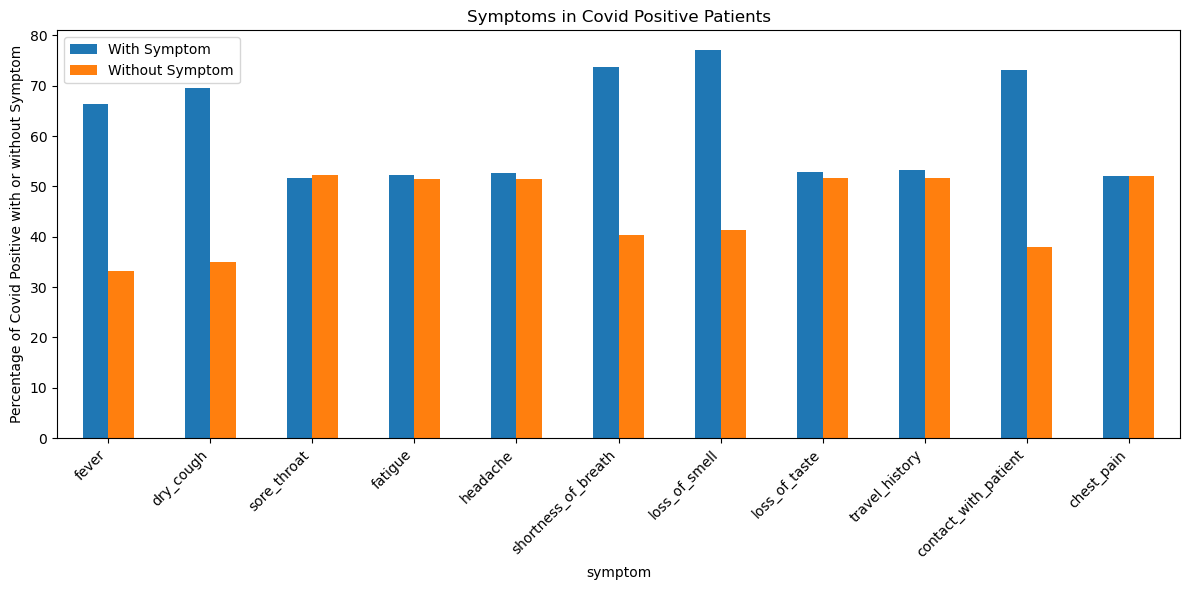

In [20]:
percent_yes.set_index('symptom')[['With Symptom', 'Without Symptom']].plot(kind='bar', figsize=(12,6))
plt.xticks(rotation=45, ha='right')
plt.title('Symptoms in Covid Positive Patients')
plt.ylabel('Percentage of Covid Positive with or without Symptom')
plt.tight_layout()
plt.show()

We can also look at this data in the opposite direction - instead of starting with the Covid positive patients and asking whether they have each symptom, we can look at the people with each symptom and ask if they have Covid.

In [ ]:
#Calculate the percentage of people with the symptom that are Covid Positive.
percent_pos = []
for col in symptom_columns:
    pct_yes = covid[covid['covid_result'] =='Positive'][col].value_counts(normalize=True).get('Yes', 0)*100
    pct_no = covid[covid['covid_result'] =='Negative'][col].value_counts(normalize=True).get('Yes', 0)*100
    percent_pos.append({'symptom':col, 'Covid_Pos':pct_yes, 'Covid_Neg': pct_no})
percent_pos = pd.DataFrame(percent_pos)
percent_pos.head()

,symptom,Covid_Pos,Covid_Neg
0,fever,72.346154,39.833333
1,dry_cough,65.961538,31.291667
2,sore_throat,41.346154,41.875000
3,fatigue,59.346154,58.583333
4,headache,45.000000,43.916667


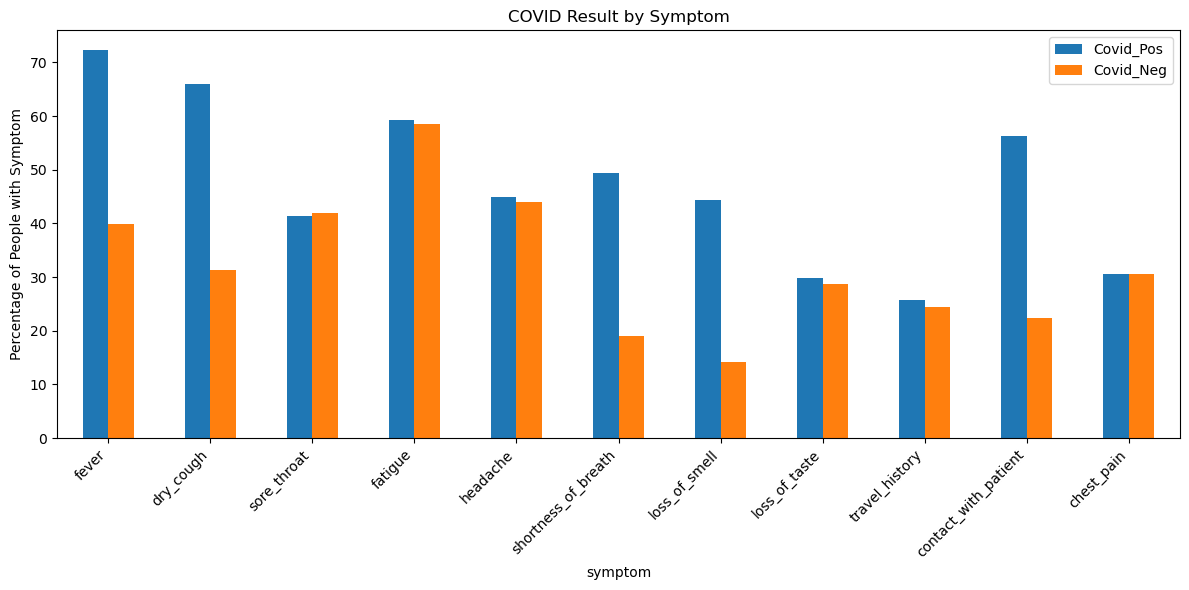

In [22]:
percent_pos.set_index('symptom')[['Covid_Pos', 'Covid_Neg']].plot(kind='bar', figsize=(12,6))
plt.xticks(rotation=45, ha='right')
plt.title('COVID Result by Symptom')
plt.ylabel('Percentage of People with Symptom')
plt.tight_layout()
plt.show()

Both of these graphs show a very similar result: Covid Positive patients tend to exhibit the five common feathres - Fever, Dry Cough, Shortness of Breath, Loss of Smell and Contact with a Covid Patient. Likewise, patients with any of these five sympotoms tend to be positive for Covid.  In contrast, the other symptoms tested are evenly distributed between Covid negative and Covid positive patients.

In this analysis, we grouped all the patients together.  However, we can stratify the patients by gender or age.  Let's look to see if symptoms differ in Covid positive patients based on gender or age.

In [41]:
#Calculate the percentage of Covid Positive Patients with each symptom by gender.
men = covid[covid['gender'] == 'Male']
women = covid[covid['gender'] == 'Female']

percent_gender = []
for col in symptom_columns:
    pct_men = men[men[col] =='Yes']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    pct_women = women[women[col] =='Yes']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    percent_gender.append({'symptom':col, 'Male':pct_men, 'Female': pct_women})
percent_gender = pd.DataFrame(percent_gender)

percent_gender.head()


,symptom,Male,Female
0,fever,66.596195,66.008463
1,dry_cough,69.353551,69.744435
2,sore_throat,52.182163,51.169591
3,fatigue,53.722334,50.891632
4,headache,53.172475,52.036199


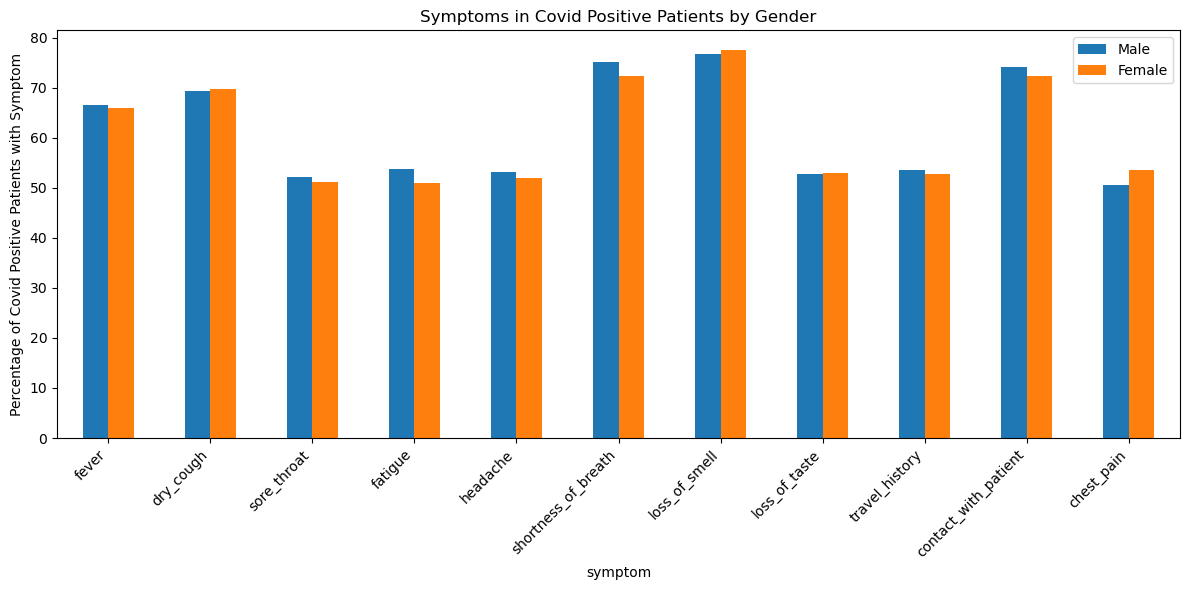

In [42]:
percent_gender.set_index('symptom')[['Male', 'Female']].plot(kind='bar', figsize=(12,6))
plt.xticks(rotation=45, ha='right')
plt.title('Symptoms in Covid Positive Patients by Gender')
plt.ylabel('Percentage of Covid Positive Patients with Symptom')
plt.tight_layout()
plt.show()

This shows us that Covid positive patients identifying as male and female have similar patterns of symptoms.  What about patients of different age groups?


(Note this is a synthetic dataset which does not account for nonbinary patients or anyone whose sex assigned at birth differs from the gender with which they currently identify.)

In [43]:
#Make new column in the covid df containing age ranges.
age_groups = ['Under 20', '20 - 34', '35 - 49', '50 - 64', '65 and Older']
age_ranges = [0, 20, 35, 50, 65, np.inf]

covid['age_range'] = pd.cut(covid['age'], labels=age_groups, bins=age_ranges)
covid[['age', 'age_range']].head()

,age,age_range
0,52,50 - 64
1,15,Under 20
2,72,65 and Older
3,61,50 - 64
4,21,20 - 34


In [44]:
#Calculate the percentage of Covid Positive Patients with each symptom by age range.
under_20 = covid[covid['age_range'] == 'Under 20']
group_34 = covid[covid['age_range'] == '20 - 34']
group_49 = covid[covid['age_range'] == '35 - 49']
group_64 = covid[covid['age_range'] == '50 - 64']
over_65 = covid[covid['age_range'] == '65 and Older']

percent_age = []
for col in symptom_columns:
    pct_20 = under_20[under_20[col] =='Yes']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    pct_34 = group_34[group_34[col] =='Yes']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    pct_49 = group_49[group_49[col] =='Yes']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    pct_64 = group_64[group_64[col] =='Yes']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    pct_65 = over_65[over_65[col] =='Yes']['covid_result'].value_counts(normalize=True).get('Positive', 0)*100
    percent_age.append({'symptom':col, 'Under 20':pct_20, '20 - 34':pct_34, '35 - 49':pct_49, '50 - 64':pct_64, '65 and Older':pct_65})
percent_age = pd.DataFrame(percent_age)

percent_age.head()

,symptom,Under 20,20 - 34,35 - 49,50 - 64,65 and Older
0,fever,65.849923,64.660194,67.108168,68.588469,65.778401
1,dry_cough,66.969147,71.824480,68.689320,72.686230,68.580542
2,sore_throat,51.515152,54.755784,50.000000,53.273810,49.714286
3,fatigue,53.254438,49.802372,50.294695,55.278311,52.510176
4,headache,53.386454,51.295337,49.333333,54.314721,53.791887


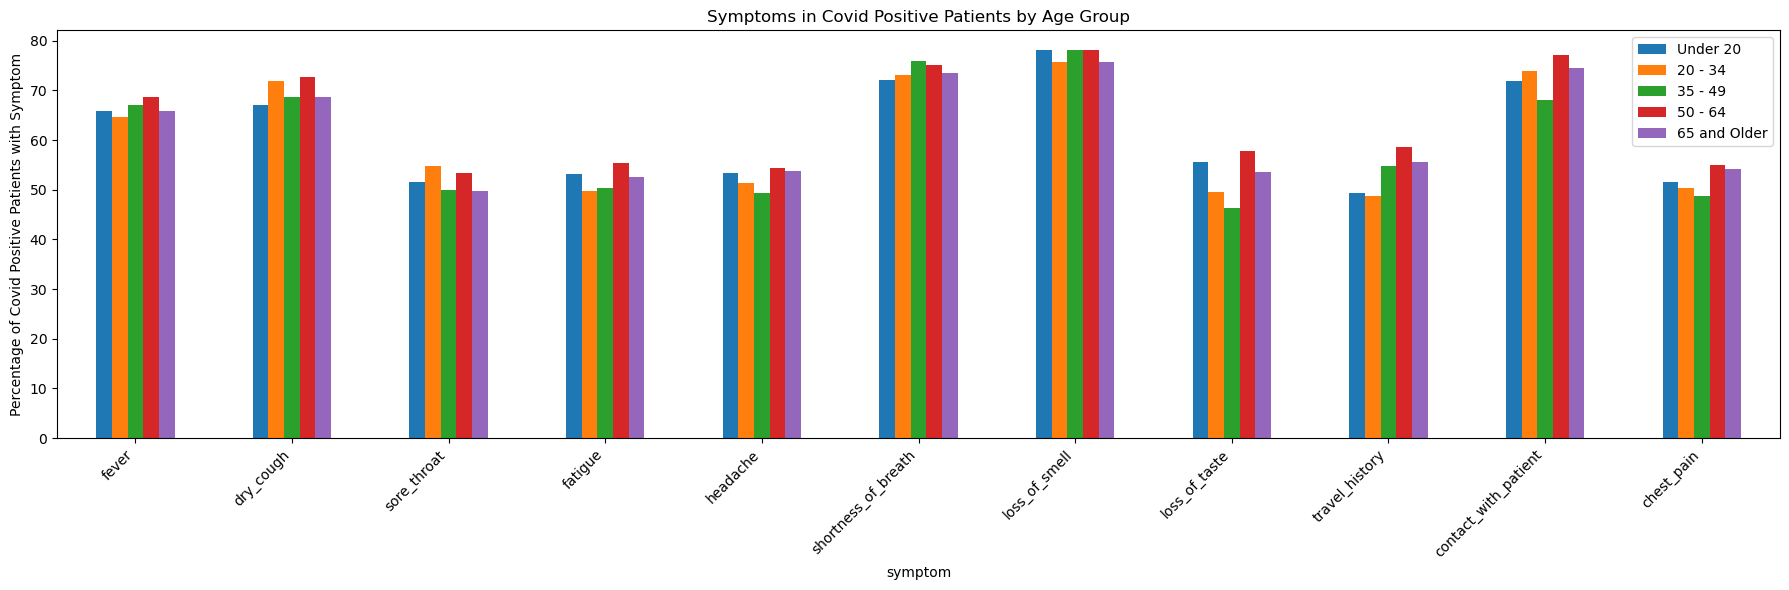

In [45]:
percent_age.set_index('symptom')[['Under 20', '20 - 34', '35 - 49', '50 - 64', '65 and Older']].plot(kind='bar', figsize=(18,6))
plt.xticks(rotation=45, ha='right')
plt.title('Symptoms in Covid Positive Patients by Age Group')
plt.ylabel('Percentage of Covid Positive Patients with Symptom')
plt.tight_layout()
plt.show()

Again, we see that Covid positive patients still tend to exhibit the same five symptoms regardless of age range.  This tells us that these five symptoms are consistently associated with a higher risk of a postive Covid result over both gender and age. If we had racial or economic data on these patients, we could continue to determine if these symptoms are universal accross groups of Covid patients from a greater variety of demographics.

Instead, let's also look at the the two numeric measurements in this data set, oxygen level and body temperature.

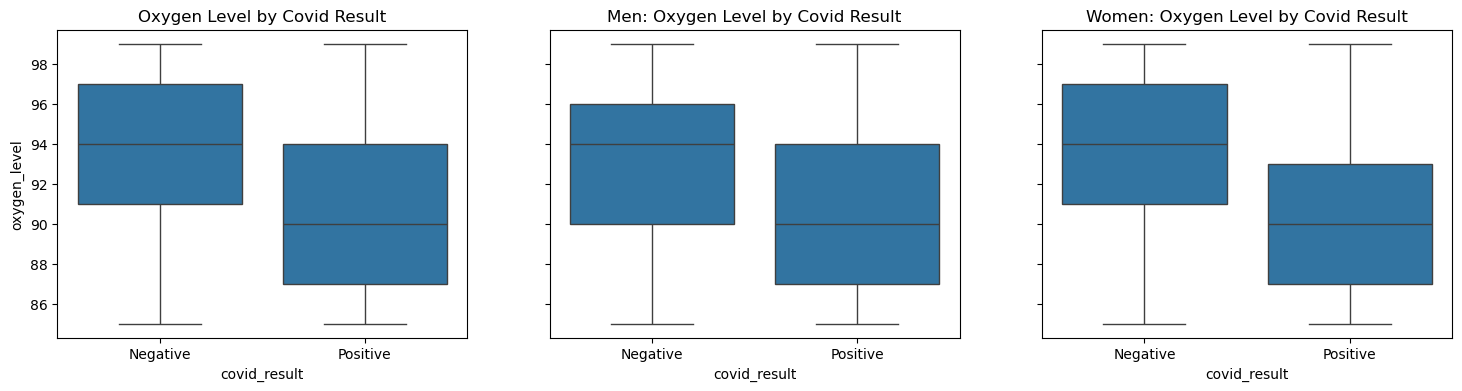

In [46]:
#Plot oxygen level by covid results in all patients, Men and Women
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharey=True)
sns.boxplot(data=covid, x='covid_result', y='oxygen_level', ax=ax[0])
sns.boxplot(data=men, x='covid_result', y='oxygen_level', ax=ax[1])
sns.boxplot(data=women, x='covid_result', y='oxygen_level', ax=ax[2])
ax[0].set_title("Oxygen Level by Covid Result")
ax[1].set_title("Men: Oxygen Level by Covid Result")
ax[2].set_title("Women: Oxygen Level by Covid Result")
plt.show()

In [60]:
from scipy.stats import f_oneway

oxy_m_pos = men[men['covid_result'] == 'Positive']['oxygen_level']
oxy_m_neg = men[men['covid_result'] == 'Negative']['oxygen_level']
oxy_w_pos = women[women['covid_result'] == 'Positive']['oxygen_level']
oxy_w_neg = women[women['covid_result'] == 'Negative']['oxygen_level']

f_statistic, p_value = f_oneway(oxy_m_pos, oxy_m_neg, oxy_w_pos, oxy_w_neg)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 166.70651271163769
P-value: 5.372888292748309e-103


This results shows us that Covid positive patients tend to have lower oxygen levels than Covid negative patients, regardless of gender.  In fact, if we run a one way Anova on the four groups of men and women, with and without Covid, we see a p value of 5.37x10^-103, which is very, very small. Given that Covid-19 is a lung infection that compromised breathing, this data is not at all surprising and helps us have confidence in our analysis.

Let's see if oxygen level also differs accross our five symptoms in Covid Positive and Covid Negative patients.

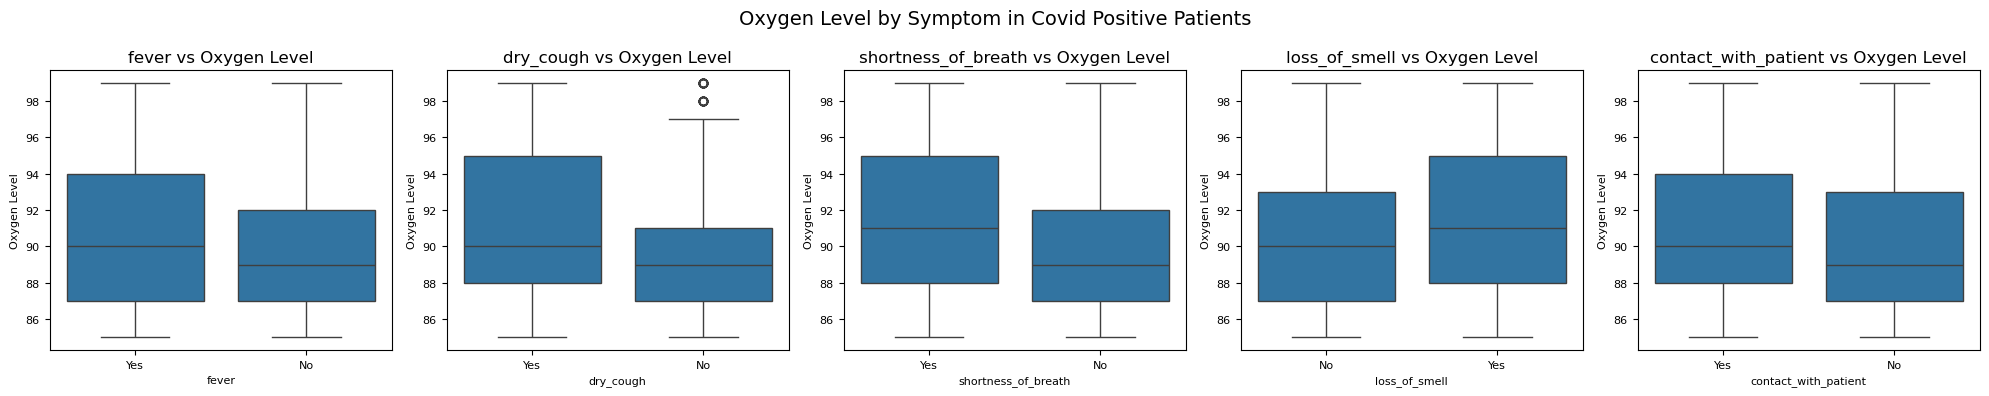

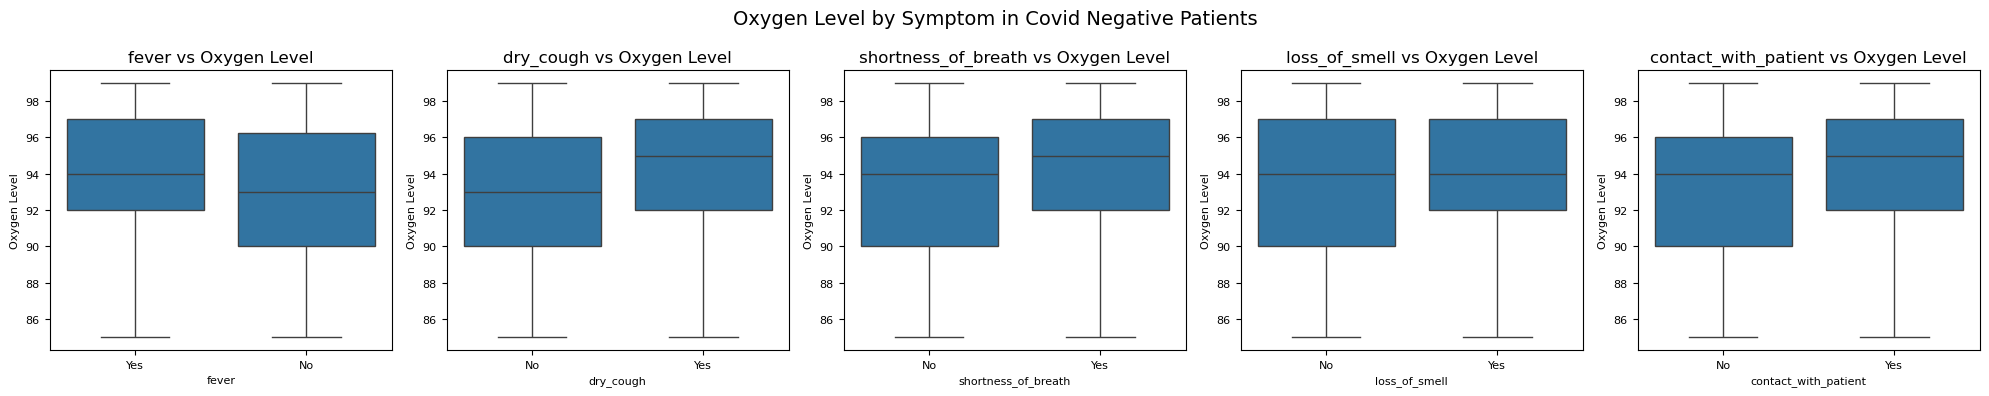

In [70]:
covid_pos = covid[covid['covid_result'] == 'Positive']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
axes = axes.flatten()
symptom_pos = ['fever', 'dry_cough', 'shortness_of_breath', 'loss_of_smell', 'contact_with_patient']
for ax, symptom in zip(axes, symptom_pos):
    sns.boxplot(data=covid_pos, x=symptom, y='oxygen_level', ax=ax)
    ax.set_title(f'{symptom} vs Oxygen Level', fontsize=12)
    ax.set_xlabel(symptom, fontsize=8)
    ax.set_ylabel("Oxygen Level", fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

plt.suptitle('Oxygen Level by Symptom in Covid Positive Patients', fontsize=14)
plt.tight_layout()
plt.show()

covid_neg = covid[covid['covid_result'] == 'Negative']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
axes = axes.flatten()
for ax, symptom in zip(axes, symptom_pos):
    sns.boxplot(data=covid_neg, x=symptom, y='oxygen_level', ax=ax)
    ax.set_title(f'{symptom} vs Oxygen Level', fontsize=12)
    ax.set_xlabel(symptom, fontsize=8)
    ax.set_ylabel("Oxygen Level", fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

plt.suptitle('Oxygen Level by Symptom in Covid Negative Patients', fontsize=14)
plt.tight_layout()
plt.show()



This result shows us how lower oxygen levels are associated with Covid-19.  In the Covid negative patients, having each symptom has no effect on the patients oxygen level.  However, in Covid positive patients, not only are overall oxygen levels lower, but oxygen levels are especially low in patients with a dry cough or shortless of breath.  This makes sense, as these are the two lung associated symptoms and may indicate that the virus has moved to the lungs and is compromisng oxygen exchange specifically in these patients. 

Let's move on to the other numeric measurement in out data set, body temperature.

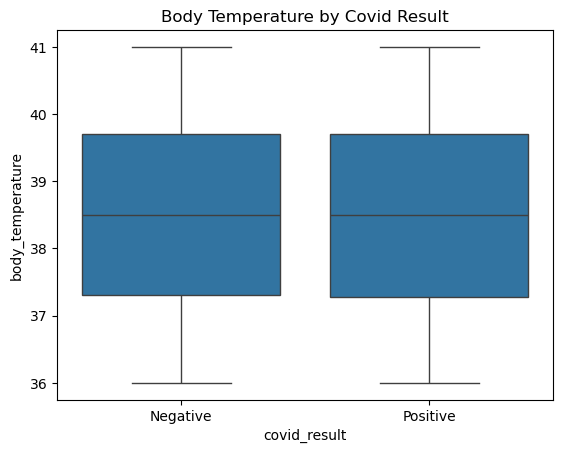

In [26]:
sns.boxplot(data=covid, x='covid_result', y='body_temperature')
plt.title("Body Temperature by Covid Result")
plt.show()

Hmmm...that's not what we expected given that a fever was one of the five symptoms that we found in Covid positive patients.  As a sanity check let's look at how body temperature corresponds to fever.

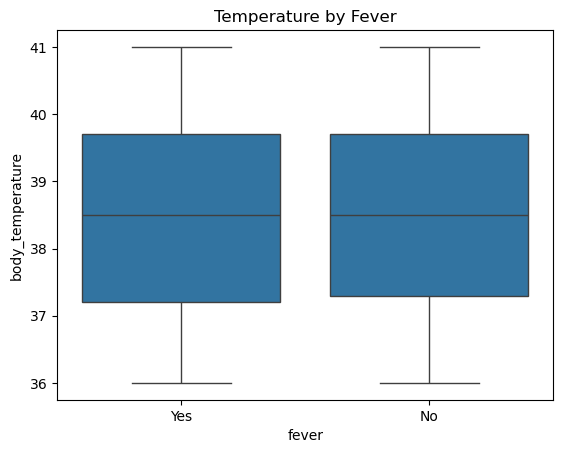

In [27]:
sns.boxplot(data=covid, x='fever', y='body_temperature')
plt.title("Temperature by Fever")
plt.show()

Well, that's definitly odd.  Any rational person would expect that patients thare are recorded as having a fever would have higher recorded body temperatures.  If this were a real project for aclient, I would consider this result justification to call a meeting and find out if this was an expected result.  In this case though, I suspect that this is an inconsistency in a synthetic data set.  We don't know how this dataset was put together, so it's possible that the author forgot to make fever and body temperature correlate.

## Combining Symptoms

Now that we have found the five symptoms that are indicative of a postive Covid result, let's see how these symtoms overlap.  To do this, we'll use UpSet plots to look at the percentage of patients with each combination of symptoms.  Just as we did above for the boxplots, we'll compare Covid positive and negative patients by plotting them on separate graphs.

In [71]:
#Prepare data for UpSet by removing all extra columns and making our columns bools with True/False instead of Yes/No.
covid_pos = covid[covid['covid_result'] == 'Positive']
covid_pos = covid_pos[['fever', 'dry_cough', 'shortness_of_breath', 'loss_of_smell', 'contact_with_patient']]

covid_neg = covid[covid['covid_result'] == 'Negative']
covid_neg = covid_neg[['fever', 'dry_cough', 'shortness_of_breath', 'loss_of_smell', 'contact_with_patient']]
for symptom in symptom_pos:
    covid_pos[symptom] = covid_pos[symptom].replace({'Yes':True, 'No':False})
    covid_neg[symptom] = covid_neg[symptom].replace({'Yes':True, 'No':False})

C:\Users\Ujval\AppData\Local\Temp\ipykernel_18164\4232849501.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  covid_pos[symptom] = covid_pos[symptom].replace({'Yes':True, 'No':False})
C:\Users\Ujval\AppData\Local\Temp\ipykernel_18164\4232849501.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  covid_neg[symptom] = covid_neg[symptom].replace({'Yes':True, 'No':False})


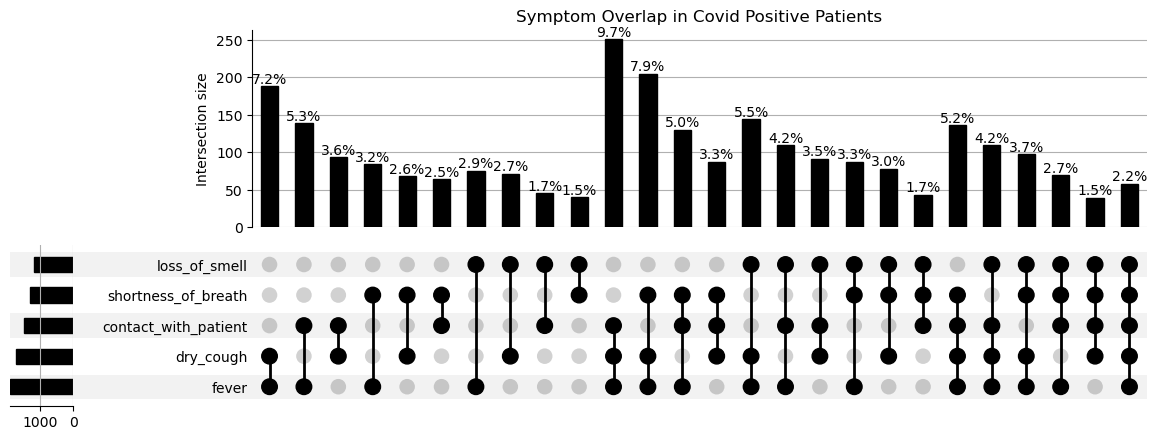

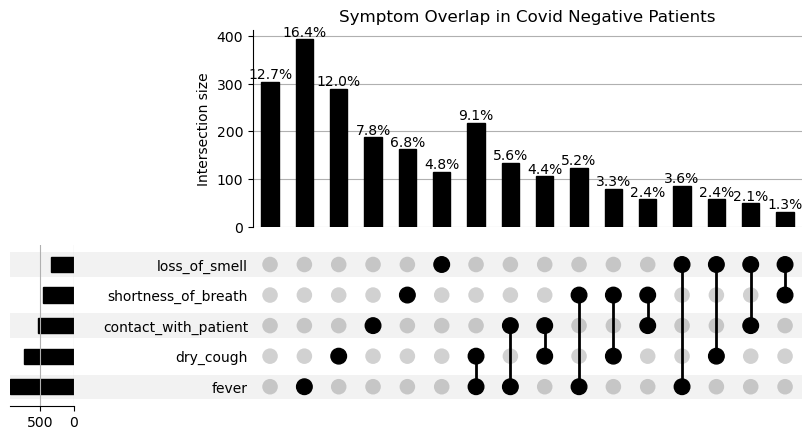

In [73]:
upset_data_pos = from_indicators(symptom_pos, covid_pos[symptom_pos])
upset_data_neg = from_indicators(symptom_pos, covid_neg[symptom_pos])
upset_pos = UpSet(upset_data_pos, show_counts=False)
axes = upset_pos.plot()
total_samples_pos = len(upset_data_pos)
ax = axes['intersections']
for patch in ax.patches:
    height = patch.get_height()
    pct = 100 * height / total_samples_pos
    ax.text(patch.get_x() + patch.get_width() / 2, height, f"{pct:.1f}%", ha="center", va="bottom")
plt.title('Symptom Overlap in Covid Positive Patients')
plt.show()


upset_neg = UpSet(upset_data_neg,show_counts=False)
axes1 = upset_neg.plot()
total_samples_neg = len(upset_data_neg)
ax = axes1['intersections']
for patch in ax.patches:
    height = patch.get_height()
    pct = 100 * height / total_samples_neg
    ax.text(patch.get_x() + patch.get_width() / 2, height, f"{pct:.1f}%", ha="center", va="bottom")
plt.title('Symptom Overlap in Covid Negative Patients')
plt.show()

Here we can see that symptoms overlap very differently between Covid positive and negative patients.  Here are a few key observations:
- 100% of Covid Positive patients have two or more of the five symptoms.
- 66.8% of Covid Positive patients have three or more symptoms.  

- 60.5% of Covid Negative patients have zero or one of the five symptoms.
- 0% of Covid Negative patients have three or more symptoms.

This information would be quite useful to health care professionals diagnosing and triaging patients.  If they have two or more of the five symptoms we identified, they are more likely to be positive for Covid-19, especially if they have low oxygen!


## Summary

In summary, we identified five symptoms associated with Covid-19 positive patients, namely fever, dry cough, shortness of breath, loss of smell and contact with another positive patient.  These symptoms are associated with positive Covid results in both males and females and accross various age ranges.  We also found that Covid postive patients tend to have lower oxygen levels, especially if they exhibit a dry cough or shortness of breath.

In addition, out other main finding was that in this data set, all Covid positive patients had at least two if the five symptoms, while only 39.5% of Covid negative patients had two symptoms.  The overlap of these two of more of these five symptoms we identified could be used to biuld a robust model to predict a patients' Covid-19 status without the need for a physical covid test, especially if test are limiting or costly.
